In [1]:
name = '2015-11-20-cartopy-example'
title = '20 November: Cartopy example'
tags = 'maps, matplotlib, xray, cartopy'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags, author)

This post is essentially a Python script that we discussed at today's meeting. It is written in a form of Jupyter Notebook and can be downloaded as a whole (the link at the end).

The script below is a simple example on how you can utulise `matplotlib` and `cartopy` awesomeness to create a pretty map. It does not claim to be original and is really inspired by the examples in the [`cartopy` gallery](http://scitools.org.uk/cartopy/docs/latest/gallery.html). [Feel free to copy it](https://opensource.org/licenses/MIT) or use wherever you want.

**Any improvements are welcome!**

### Prepare the tools

Without further ado, let's start with importing all the necessary modules

This magic command tells the notebook to put the figures inline (you don't need it if you running the code outside the Jupyter):

In [3]:
%matplotlib inline

To get rid of some unimportant warnings we do the following (in general, it's better **not** to use this).

In [4]:
import warnings
warnings.filterwarnings('ignore')

The import below is not necessary, but useful and lets you convert the code to Python 3 quicker. Basically it replaces the 'old' `print` statement with the proper `print` function. Importing `division` means using the division command (`/`) from Python 3.

Futher reading: [`__future__` - Future statement definitions](https://docs.python.org/2/library/__future__.html)

In [5]:
from __future__ import print_function, division

Now, to the import of the necessary modules.

In [6]:
import cartopy.util # Cartopy utilities submodule
import cartopy.crs as ccrs # Coordinate reference systems
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom
import xray # instead we could have used the plain netcdf4 module to read the data

And finally, we also import some instances useful for formatting

In [7]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER # Fancy formatting
import matplotlib as mpl
from matplotlib.transforms import offset_copy

In [8]:
mpl.rcParams['mathtext.default'] = 'regular' # Makes Math text regular and not LaTeX-style

Norwich - A Fine City

In [9]:
city = dict(lat=52.628333, lon=1.296667, name=u'Norwich')

### Read the data

Open a sample dataset using `xray`. The ['data.nc'](https://github.com/ueapy/ueapy.github.io/blob/src/content/data/data.nc) file is available in this website repository. Source: [ERA-Interim reanalysis](http://www.ecmwf.int/en/research/climate-reanalysis/era-interim).

In [10]:
da = xray.open_dataset('../data/data.nc')

Print out the dataset info:

In [11]:
print(da)

<xray.Dataset>
Dimensions:    (latitude: 241, level: 4, longitude: 480, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * level      (level) int32 700 800 900 1000
  * time       (time) datetime64[ns] 2015-01-31 2015-01-31T12:00:00
Data variables:
    w          (time, level, latitude, longitude) float64 -0.0713 -0.0713 ...
    vo         (time, level, latitude, longitude) float64 -6.332e-06 ...
    d          (time, level, latitude, longitude) float64 -4.835e-06 ...
    u          (time, level, latitude, longitude) float64 12.18 12.23 12.27 ...
    v          (time, level, latitude, longitude) float64 3.379 3.219 3.059 ...
Attributes:
    Conventions: CF-1.0
    history: 2015-04-26 19:20:07 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls03-a562cefde8a29a7288fa0b8b7f9413f7-Msj0Ul.target -o /data/data04/scratch/netcdf-atls03-a56

In this example we will only use the relative vorticity (`vo`) data field.

### Prepare the data for plotting

As we saw at the meeting when we first plotted the data on the map, there is a gap at the prime meridian. But `cartopy` has a useful function to make an array cyclic in the chosen coordinate.

In [12]:
cyclic_data, cyclic_lons = cartopy.util.add_cyclic_point(da.vo.data, coord=da.longitude.data)
lats = da.latitude.data

In addition, we scale the vorticity data by 1000 just for convenience.

In [13]:
cyclic_data = cyclic_data*1e3

Now we can create an array of contour levels:

In [14]:
clevs = np.arange(-0.5,0.55,0.05)

In [15]:
print(clevs)

[ -5.00000000e-01  -4.50000000e-01  -4.00000000e-01  -3.50000000e-01
  -3.00000000e-01  -2.50000000e-01  -2.00000000e-01  -1.50000000e-01
  -1.00000000e-01  -5.00000000e-02  -1.11022302e-16   5.00000000e-02
   1.00000000e-01   1.50000000e-01   2.00000000e-01   2.50000000e-01
   3.00000000e-01   3.50000000e-01   4.00000000e-01   4.50000000e-01
   5.00000000e-01]


### Create a contour plot

We don't want to make a global map, so we define a bounding box with the following boundaries: `[east_longitude, west_longitude, south_latitude, north_latitude]`.

In [16]:
bbox = [-10, 10, 45, 60]

The following big cell of code is the core of this notebook and can be intimidating, but we'll try to dilute it with some comments. Once again, it's just a compilation of `matplotlib` recipies and `stackoverflow` answers, nothing superhuman.

Here's our map!


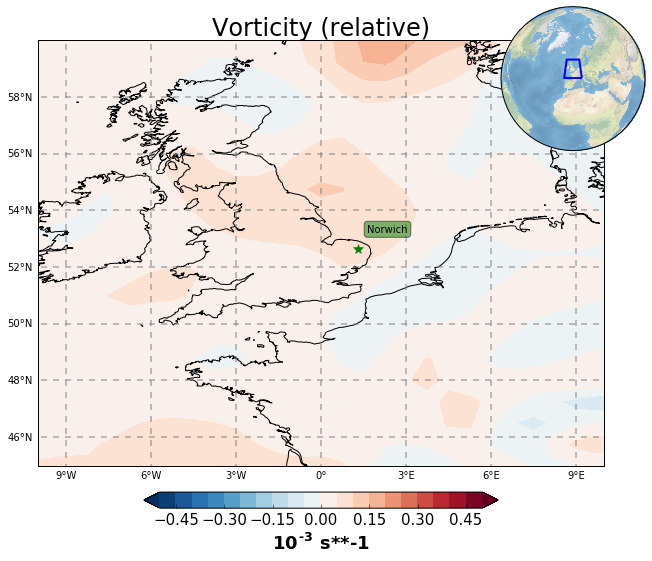

In [17]:
# Define figure of size (25,10) and an axis 'inside' with an equirectangular projection
fig, ax = plt.subplots(figsize=(20,8), subplot_kw=dict(projection=ccrs.PlateCarree()))
# Set the map extent using the bbox defined above
ax.set_extent(bbox)
# Draw coast line with the highest resolution available (unless you use a different source)
ax.coastlines('10m')

#
# Create a filled contour plot
#
# For the mappable array we use the first slice in time and the first level in the vertical coordinate, 
# hence: cyclic_data[0,0,...]
# 
c = ax.contourf(cyclic_lons, lats, cyclic_data[0,0,...], 
                clevs, # Contour levels defined above
                cmap=plt.cm.RdBu_r, # A standard diverging colormap, from Blue to Red
                extend='both' # To make pointy colorbar
               )
#
# Create a colorbar
#
cb = plt.colorbar(c, # connect it to the contour plot
                  ax=ax, # put it in the same axis
                  orientation='horizontal',
                  shrink=0.25, # shrink its size by 4
                  pad = 0.05 # shift it up
                 )
# Colorbar label: units of vorticity
cb.set_label('$10^{-3}$ '+da.vo.units, fontsize=18, fontweight='bold')
# Increase the font size of tick labels
cb.ax.tick_params(labelsize=15)

# Title of the plot
ax.set_title(da.vo.long_name, fontsize=24)

#
# Grid lines
#
gl = ax.gridlines(crs=ccrs.PlateCarree(), # using the same projection
                  draw_labels=True, # add labels
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # grid line specs
# Remove labels above and on the right of the map (note that Python allows the double equality)
gl.xlabels_top = gl.ylabels_right = False
# Format the labels using the formatters imported from cartopy
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#
# Norwich
#
# Mark our location with a green asterisk
ax.plot(city['lon'], city['lat'], linestyle='None', marker='*', ms=10, mfc='g', mec='g')
# Add a label next to the marker using matplotlib.transform submodule
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=50, y=20)
ax.text(city['lon'], city['lat'], city['name'],
         verticalalignment='center', horizontalalignment='right',
         transform=text_transform,
         bbox=dict(facecolor='g', alpha=0.5, boxstyle='round'))

#
# Additional axis
#
sub_ax = plt.axes([0.55, 0.75, 0.25, 0.25], # Add an inset axis at (0.55,0.75) with 0.2 for width and height
                  projection=ccrs.Orthographic(central_latitude=45.0) # Not a simple axis, but another cartopy geoaxes instance
                 )
# The whole globe
sub_ax.set_global()
# Paint it
sub_ax.stock_img()
# Using shapely module, create a bounding box to denote the map boundaries
extent_box = sgeom.box(bbox[0], bbox[2], bbox[1], bbox[3])
sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=2)

# Tighten the figure layout
fig.tight_layout()
# Print a success message
print("Here's our map!")

Uncomment the following line to save the figure:

In [18]:
#fig.savefig('cartopy_rules.jpg')

In [19]:
HTML(html)